# Analiza

Na osnovu f1 ocene da se zaključiti da model koji najbolje predviđa je potpuno konvoluciona neuronska mreža.

Ocenićemo ga na osnovu skupa podataka u direktorijumu `/content/drive/MyDrive/MasinskoUcenjeChestXRay/resources/scaled/test` pošto su ti podaci do sada potpuno netaknuti i predstavljaju nove slike koje nijedan model do sada nije video.

In [1]:
import numpy as np
from PIL import Image
import os

In [2]:
data_dir = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/resources/scaled"

In [4]:
def load_images_to_numpy(src_path: str) -> np.ndarray:
    res = os.listdir(src_path)
    res = map(lambda path: os.path.join(src_path, path), res)
    res = map(Image.open, res)
    res = map(np.asarray, res)
    res = np.stack([*res], axis=0)
    return res

def load_images(src_path: str):
    X_false = load_images_to_numpy(os.path.join(src_path, "NORMAL"))
    y_false = np.zeros((X_false.shape[0],), dtype=np.uint8)

    X_true = load_images_to_numpy(os.path.join(src_path, "PNEUMONIA"))
    y_true = np.ones((X_true.shape[0],), dtype=np.uint8)

    X = np.concatenate([X_false, X_true])
    y = np.concatenate([y_false, y_true])
    return (X, y)

X, y = load_images(os.path.join(data_dir, "test"))

In [6]:
model_base_path = '/content/drive/MyDrive/MasinskoUcenjeChestXRay/models/'

model_names = ['simple', 'small', 'noise', 'fully_convolutional', 'alexnet', 'vgg16']
best_model_name = 'fully_convolutional'

model_paths = {
    model_name : os.path.join(model_base_path, model_name, 'model.h5')
    for model_name in model_names
}

In [9]:
from tensorflow.keras.models import load_model

In [10]:
models = {
    model_name : load_model(model_path)
    for model_name, model_path in model_paths.items()
}

In [11]:
y_preds = {
    model_name : model.predict(X)
    for model_name, model in models.items()
}

20/20 [==============================] - 18s 449ms/step


In [12]:
from sklearn.metrics import roc_curve, auc

In [14]:
roc_curves = {
    model_name : roc_curve(y, y_pred)
    for model_name, y_pred in y_preds.items()
}

aucs = {
    model_name : auc(y, y_pred)
    for model_name, y_pred in y_preds.items()
}

In [ ]:
import matplotlib.pyplot as plt

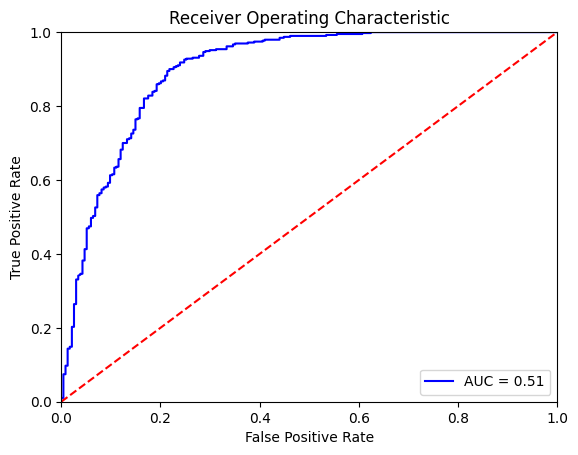

In [19]:
def plot_roc(model_name):
    fpr, tpr, threshold = roc_curves[model_name]
    auc_score = aucs[model_name]

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

plot_roc(best_model_name)

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import pandas as pd
import numpy as np

In [ ]:
precisions, recalls, fscores = {}, {}, {}

for model_name, y_pred in y_preds.items():
    y_pred_round = np.where(y_pred < 0.5, 0, 1)
    precision, recall, fscore, _ = precision_recall_fscore_support(y, y_pred_round, average='binary')
    precisions[model_name] = precision
    recalls[model_name] = recall
    fscores[model_name] = fscore

In [47]:
def reports(model_name, print_reports=True):
    if(print_reports):
        y_pred_round = np.where(y_preds[model_name] < 0.5, 0, 1)
        print(classification_report(y, y_pred_round))
        cmatrix = confusion_matrix(y, y_pred_round)
        labels = ["NORMAL", "PNEUMONIA"]
        print(pd.DataFrame(cmatrix, index=labels, columns=labels))
    return (
        precisions[model_name],
        recalls[model_name],
        fscores[model_name]
    )

_ = reports(best_model_name)

              precision    recall  f1-score   support

           0       1.00      0.35      0.51       234
           1       0.72      1.00      0.84       390

    accuracy                           0.75       624
   macro avg       0.86      0.67      0.68       624
weighted avg       0.82      0.75      0.72       624

           NORMAL  PNEUMONIA
NORMAL         81        153
PNEUMONIA       0        390


Model bez greške pogađa da je osoba zdrava. Iako za samo 17% instanci uopšte kaže negativnu vrednost, ovakav model ima upotrebnu vrednost. Nije poenta u preciznosti pozitivnih, već u odzivu negativnih. U ovom specifičnom slučaju nam odgovara da model nikada ne kaže za osobu koja je bolesna da je zdrava jer može ostati bez neophodnog lečenja. Ovakav model može biti preliminarni test koji određene ljude ne prosleđuje doktoru čime se štedi ljudsko vreme.

Ukoliko nam je potreban opštiji klasifikator ROC kriva sugeriše da nameštanjem odsečne tačke može malo da se relaksira model. Treniranje ovakvog hiper parametra trenutno više nije moguće jer su test podaci već pogledani i samim tim implicitno učestvuju u treningu (ne bi se mogao pouzdano evaluirati model nakon novog treninga).

Sumirano, model je definitvno naučio da prepoznaje zdrava pluća, a pošto koristimo potpuno konvolucionu mrežu to sugeriše da je model našao neki niz osobina pluća na osnovu kojih je ovakva klasifikacija moguća.

Postoji mogućnost da je ova situacija odlika test skupa. Test skup nisam ja pravio već je unapred pripremljen, što znači da instance u test skupu možda nisu skroz nasumične slike već su ubačeni neki potpuno novi slučajevi kompletno nepoznati modelu.

Radi eksperimenta testiraću i ostale modele i uporediću ih po istom kriterijumu (iako je najbolji model već odabran i biranje novog modela na osnovu ovih testova bi pokvarilo validnost evaluacije).

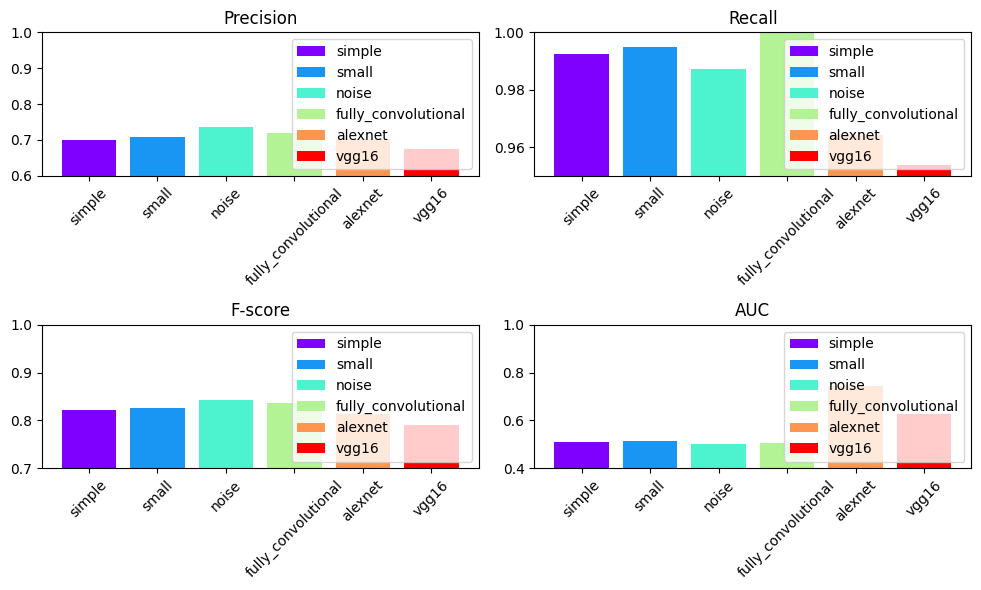

In [57]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

metrics = {
    'Precision' : precisions,
    'Recall' : recalls,
    'F-score' : fscores,
    'AUC' : aucs
}

ylims = {
    'Precision' : (0.6, 1.0),
    'Recall' : (0.95, 1.0),
    'F-score' : (0.7, 1.0),
    'AUC' : (0.4, 1.0)
}

plt.figure(figsize=(10, 6))

for i, (metric, metric_data) in enumerate(metrics.items()):
    plt.subplot(2, 2, i+1)
    for model, color in zip(models, colors):
        plt.bar(model, metric_data[model], color=color, label=model)

    plt.title(metric)
    plt.ylim(*ylims[metric])
    plt.legend()
    plt.xticks(rotation=45)
plt.tight_layout()

Modeli koje sam ja pisao dosta su slični u performansama. Verovatno bi dodatno treniranje potpomoglo. Poznati modeli (alexnet i vgg16) imaju dosta veće AUC vrednosti, što ima smisla jer su ti modeli dosta veći i predviđeni za veće probleme klasifikacije (mada je pitanje da li bi mogli pouzdano da se istreniraju na ovako malom skupu podataka).

Čitanjem komentara sa kaggle sajta vidim da su ljudi dobijali slične rezultate kao ja (malo su bolje preciznosti, ali često nije korišćena samo konvoluc)